# 🧠 Pipeline Complet Wide+Deep FIXED - Classification ECG PTB-XL

---

## 📋 Informations

| Métrique | Valeur |
|----------|--------|
| **Modèle Final** | `model_wide_deep_pure_FIXED.pth` |
| **Performance** | **91.98% AUC Macro** |
| **Dataset** | PTB-XL (21,481 ECG) |
| **Classes** | NORM, MI, STTC, CD, HYP |
| **Architecture** | Wide+Deep (11.5M params) |

---

## 📑 Table des Matières

1. **Configuration & Imports**
2. **STEP 0: Prétraitement Initial (CSV → Features)**
3. **STEP 1: Chargement depuis Excel**
4. **STEP 2: Nettoyage des Signaux ECG**
5. **STEP 3: Extraction Features Wide (NeuroKit2)**
6. **STEP 4: Préparation Features Wide**
7. **STEP 5: Architecture Wide+Deep**
8. **STEP 6: Entraînement FIXED** ⭐
9. **STEP 7: Évaluation & Courbes ROC**
10. **Utilisation du Modèle**

---

# 1️⃣ Configuration & Imports

In [11]:
"""
═══════════════════════════════════════════════════════════════════════════════
CONFIGURATION ET IMPORTS
═══════════════════════════════════════════════════════════════════════════════
"""

# ===== Standard Libraries =====
import os
import sys
import ast
import json
import warnings
from pathlib import Path
from datetime import datetime
from collections import Counter
from tqdm import tqdm

# ===== IMPORTANT: Changer vers le répertoire contenant les données =====
# Le notebook est dans le dossier parent, mais les données sont dans le sous-dossier
DATA_DIR = Path(r"c:\Users\HATIM\Desktop\projet analytics\Nouveau dossier (2)\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3 - Copie\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3")
os.chdir(DATA_DIR)
print(f"📁 Répertoire de travail: {os.getcwd()}")

# ===== Data Processing =====
import numpy as np
import pandas as pd

# ===== Machine Learning - Sklearn =====
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

# ===== Deep Learning - PyTorch =====
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import math

# ===== Signal Processing =====
import wfdb
import neurokit2 as nk

# ===== Visualization =====
import matplotlib.pyplot as plt
import seaborn as sns

# ===== Settings =====
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

# ===== Device Configuration =====
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# ===== Global Configuration =====
CONFIG = {
    'BATCH_SIZE': 32,
    'LEARNING_RATE': 1e-4,
    'WEIGHT_DECAY': 1e-4,
    'EPOCHS': 50,
    'PATIENCE': 10,
    'NUM_CLASSES': 5,
    'SAMPLING_RATE': 100,
    'SIGNAL_LENGTH': 1000,
    'N_LEADS': 12,
    'WIDE_DIM': 32,
}

CLASS_NAMES = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
CLASS_COLORS = ['#27ae60', '#e74c3c', '#3498db', '#9b59b6', '#f39c12']

print("\n✅ Configuration chargée!")
print(f"  • Batch size: {CONFIG['BATCH_SIZE']}")
print(f"  • Learning rate: {CONFIG['LEARNING_RATE']}")
print(f"  • Classes: {CLASS_NAMES}")

📁 Répertoire de travail: c:\Users\HATIM\Desktop\projet analytics\Nouveau dossier (2)\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3 - Copie\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3
PyTorch version: 2.5.1+cu121
Device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU

✅ Configuration chargée!
  • Batch size: 32
  • Learning rate: 0.0001
  • Classes: ['NORM', 'MI', 'STTC', 'CD', 'HYP']


---

# 2️⃣ STEP 0: Prétraitement Initial (CSV → Features)

Ce script prend `ptbxl_database.csv` et génère les fichiers de features prétraitées.

In [12]:
"""
═══════════════════════════════════════════════════════════════════════════════
STEP 0: PREPROCESSING PROFESSIONNEL - PTB-XL Database
═══════════════════════════════════════════════════════════════════════════════
Pipeline:
  1. Chargement ptbxl_database.csv + scp_statements.csv
  2. Suppression outliers (age, height, weight)
  3. Feature engineering (BMI, age_group, quality_score)
  4. Encodage codes SCP (top 30 + 5 superclasses)
  5. Imputation KNN (height, weight) + Mode (catégorielles)
  6. Encodage variables (One-Hot, Label)
  7. Normalisation RobustScaler
  8. Split Train/Val/Test (strat_fold 1-8/9/10)
"""

print("═" * 100)
print(" " * 25 + "STEP 0: PREPROCESSING PROFESSIONNEL")
print("═" * 100)

# ─────────────────────────────────────────────────────────────────────────────
# 0.1 CHARGEMENT DES DONNÉES
# ─────────────────────────────────────────────────────────────────────────────
print("\n[1/8] Chargement des données...")

df_original = pd.read_csv('ptbxl_database.csv', index_col='ecg_id')
scp_df = pd.read_csv('scp_statements.csv', index_col=0)

print(f"  ✓ Dataset original: {df_original.shape[0]:,} × {df_original.shape[1]}")
print(f"  ✓ Codes SCP: {len(scp_df)} diagnostics")

df = df_original.copy()
df['scp_codes'] = df['scp_codes'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['recording_date'] = pd.to_datetime(df['recording_date'], errors='coerce')

# ─────────────────────────────────────────────────────────────────────────────
# 0.2 SUPPRESSION DES OUTLIERS
# ─────────────────────────────────────────────────────────────────────────────
print("\n[2/8] Suppression des outliers...")

n_before = len(df)

# Age: 0-120 ans
df = df[(df['age'] >= 0) & (df['age'] <= 120)]

# Weight: 30-250 kg
df = df[(df['weight'].isna()) | ((df['weight'] >= 30) & (df['weight'] <= 250))]

# Height: 130-230 cm
df = df[(df['height'].isna()) | ((df['height'] >= 130) & (df['height'] <= 230))]

n_after = len(df)
print(f"  ✓ Outliers supprimés: {n_before - n_after}")
print(f"  ✓ Dataset après nettoyage: {n_after:,} ({100*n_after/n_before:.2f}%)")

# ─────────────────────────────────────────────────────────────────────────────
# 0.3 FEATURE ENGINEERING
# ─────────────────────────────────────────────────────────────────────────────
print("\n[3/8] Feature Engineering...")

# BMI
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)

# Age groups
df['age_group'] = pd.cut(df['age'], 
                         bins=[0, 18, 35, 50, 65, 80, 120],
                         labels=['<18', '18-35', '35-50', '50-65', '65-80', '80+'])

# BMI categories
df['bmi_category'] = pd.cut(df['bmi'],
                            bins=[0, 18.5, 25, 30, 40, 100],
                            labels=['Underweight', 'Normal', 'Overweight', 'Obese', 'Severe Obese'])

# Temporal features
df['year'] = df['recording_date'].dt.year
df['month'] = df['recording_date'].dt.month
df['day_of_week'] = df['recording_date'].dt.dayofweek
df['quarter'] = df['recording_date'].dt.quarter

# Quality features
quality_cols = ['baseline_drift', 'static_noise', 'extra_beats']
for col in quality_cols:
    if col in df.columns:
        df[col] = df[col].notna().astype(int)

df['quality_issues_count'] = df[quality_cols].sum(axis=1)
df['quality_score'] = 3 - df['quality_issues_count']

# Validation features
df['is_validated'] = df['validated_by'].notna().astype(int)
df['num_scp_codes'] = df['scp_codes'].apply(lambda x: len(x) if isinstance(x, dict) else 0)

print("  ✓ Features créées: BMI, age_group, bmi_category, temporal, quality")

# ─────────────────────────────────────────────────────────────────────────────
# 0.4 ENCODAGE CODES SCP
# ─────────────────────────────────────────────────────────────────────────────
print("\n[4/8] Encodage codes SCP...")

# Top 30 codes
all_codes = []
for codes_dict in df['scp_codes']:
    if isinstance(codes_dict, dict):
        all_codes.extend(list(codes_dict.keys()))

code_counter = Counter(all_codes)
top_codes = [code for code, count in code_counter.most_common(30)]

for code in top_codes:
    df[f'scp_{code}'] = df['scp_codes'].apply(
        lambda x: 1 if isinstance(x, dict) and code in x else 0
    )

# Superclasses
df['scp_superclass_NORM'] = df['scp_codes'].apply(
    lambda x: 1 if isinstance(x, dict) and any(k in ['NORM'] for k in x.keys()) else 0
)
df['scp_superclass_MI'] = df['scp_codes'].apply(
    lambda x: 1 if isinstance(x, dict) and any(k in ['IMI', 'ASMI', 'LMI', 'AMI', 'ILMI', 'PMI'] for k in x.keys()) else 0
)
df['scp_superclass_STTC'] = df['scp_codes'].apply(
    lambda x: 1 if isinstance(x, dict) and any(k in ['STTC', 'NDT', 'NST_', 'DIG', 'LNGQT'] for k in x.keys()) else 0
)
df['scp_superclass_CD'] = df['scp_codes'].apply(
    lambda x: 1 if isinstance(x, dict) and any(k in ['CD', '1AVB', '2AVB', '3AVB', 'LAFB', 'IRBBB', 'CRBBB'] for k in x.keys()) else 0
)
df['scp_superclass_HYP'] = df['scp_codes'].apply(
    lambda x: 1 if isinstance(x, dict) and any(k in ['HYP', 'LVH', 'RVH', 'LAO/LAE', 'RAO/RAE'] for k in x.keys()) else 0
)

print(f"  ✓ {len(top_codes)} codes SCP encodés")
print(f"  ✓ 5 superclasses créées")

# ─────────────────────────────────────────────────────────────────────────────
# 0.5 IMPUTATION
# ─────────────────────────────────────────────────────────────────────────────
print("\n[5/8] Imputation des valeurs manquantes...")

# Height & Weight: KNN Imputation
imputer = KNNImputer(n_neighbors=5, weights='distance')

# Height
temp_data = df[['age', 'sex', 'weight', 'height']].copy()
temp_data_imputed = imputer.fit_transform(temp_data)
df['height'] = temp_data_imputed[:, 3]

# Weight
temp_data = df[['age', 'sex', 'height', 'weight']].copy()
temp_data_imputed = imputer.fit_transform(temp_data)
df['weight'] = temp_data_imputed[:, 3]

# Recalculate BMI
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)

# Heart axis: Mode
if df['heart_axis'].isnull().sum() > 0:
    global_mode = df['heart_axis'].mode()[0] if not df['heart_axis'].mode().empty else 'MID'
    df['heart_axis'].fillna(global_mode, inplace=True)

print("  ✓ KNN Imputation (height, weight)")
print("  ✓ Mode Imputation (heart_axis)")

# ─────────────────────────────────────────────────────────────────────────────
# 0.6 ENCODAGE CATÉGORIEL
# ─────────────────────────────────────────────────────────────────────────────
print("\n[6/8] Encodage catégoriel...")

# One-Hot Encoding
age_group_dummies = pd.get_dummies(df['age_group'], prefix='age_group')
df = pd.concat([df, age_group_dummies], axis=1)

bmi_cat_dummies = pd.get_dummies(df['bmi_category'], prefix='bmi_cat')
df = pd.concat([df, bmi_cat_dummies], axis=1)

# Label Encoding
le_site = LabelEncoder()
df['site_encoded'] = le_site.fit_transform(df['site'].astype(str))

le_device = LabelEncoder()
df['device_encoded'] = le_device.fit_transform(df['device'].astype(str))

le_heart_axis = LabelEncoder()
df['heart_axis_encoded'] = le_heart_axis.fit_transform(df['heart_axis'].astype(str))

print("  ✓ One-Hot: age_group, bmi_category")
print("  ✓ Label Encoding: site, device, heart_axis")

# ─────────────────────────────────────────────────────────────────────────────
# 0.7 NORMALISATION
# ─────────────────────────────────────────────────────────────────────────────
print("\n[7/8] Normalisation...")

numeric_features = ['age', 'height', 'weight', 'bmi', 'quality_score', 
                   'quality_issues_count', 'num_scp_codes', 'year', 'month']

scaler = RobustScaler()
for feature in numeric_features:
    if feature in df.columns:
        df[f'{feature}_scaled'] = scaler.fit_transform(df[[feature]])

print(f"  ✓ RobustScaler sur {len(numeric_features)} features")

# ─────────────────────────────────────────────────────────────────────────────
# 0.8 SPLIT ET SAUVEGARDE
# ─────────────────────────────────────────────────────────────────────────────
print("\n[8/8] Split et sauvegarde...")

# Nettoyer colonnes non nécessaires
columns_to_drop = ['electrodes_problems', 'infarction_stadium2', 'pacemaker', 
                   'burst_noise', 'infarction_stadium1', 'report', 
                   'initial_autogenerated_report', 'scp_codes', 'age_group',
                   'bmi_category', 'recording_date', 'second_opinion', 'validated_by']

existing_cols = [col for col in columns_to_drop if col in df.columns]
df.drop(columns=existing_cols, inplace=True)

# Split
df_train = df[df['strat_fold'].isin(range(1, 9))].copy()
df_val = df[df['strat_fold'] == 9].copy()
df_test = df[df['strat_fold'] == 10].copy()

print(f"  ✓ Train: {len(df_train):,} ({100*len(df_train)/len(df):.1f}%)")
print(f"  ✓ Val: {len(df_val):,} ({100*len(df_val)/len(df):.1f}%)")
print(f"  ✓ Test: {len(df_test):,} ({100*len(df_test)/len(df):.1f}%)")

# Sauvegarder
df_train.to_csv('ptbxl_ml_features_train.csv')
df_val.to_csv('ptbxl_ml_features_val.csv')
df_test.to_csv('ptbxl_ml_features_test.csv')

print("\n✅ STEP 0 TERMINÉ - Fichiers CSV générés!")

════════════════════════════════════════════════════════════════════════════════════════════════════
                         STEP 0: PREPROCESSING PROFESSIONNEL
════════════════════════════════════════════════════════════════════════════════════════════════════

[1/8] Chargement des données...
  ✓ Dataset original: 21,799 × 27
  ✓ Codes SCP: 71 diagnostics

[2/8] Suppression des outliers...
  ✓ Outliers supprimés: 318
  ✓ Dataset après nettoyage: 21,481 (98.54%)

[3/8] Feature Engineering...
  ✓ Features créées: BMI, age_group, bmi_category, temporal, quality

[4/8] Encodage codes SCP...
  ✓ 30 codes SCP encodés
  ✓ 5 superclasses créées

[5/8] Imputation des valeurs manquantes...
  ✓ KNN Imputation (height, weight)
  ✓ Mode Imputation (heart_axis)

[6/8] Encodage catégoriel...
  ✓ One-Hot: age_group, bmi_category
  ✓ Label Encoding: site, device, heart_axis

[7/8] Normalisation...
  ✓ RobustScaler sur 9 features

[8/8] Split et sauvegarde...
  ✓ Train: 17,182 (80.0%)
  ✓ Val: 2,137 (

---

# 3️⃣ STEP 1: Création Excel avec Filenames

In [13]:
"""
═══════════════════════════════════════════════════════════════════════════════
STEP 1: CRÉATION EXCEL AVEC filename_lr/filename_hr
═══════════════════════════════════════════════════════════════════════════════
"""

print("═" * 70)
print("STEP 1: CRÉATION EXCEL AVEC FILENAMES")
print("═" * 70)

# Vérifier les colonnes
print("\n[1/2] Vérification des colonnes...")
df_train = pd.read_csv('ptbxl_ml_features_train.csv')

if 'filename_lr' in df_train.columns and 'filename_hr' in df_train.columns:
    print("  ✓ filename_lr: PRÉSENT")
    print("  ✓ filename_hr: PRÉSENT")
    print(f"  Exemple: {df_train['filename_lr'].iloc[0]}")
else:
    print("  ✗ ERREUR: Colonnes filename manquantes!")

# Créer Excel avec gestion d'erreur
print("\n[2/2] Création du fichier Excel...")
excel_filename = 'PTB_XL_ML_Features_WITH_FILENAMES.xlsx'

# Si le fichier existe et est verrouillé, utiliser un nom alternatif
try:
    with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
        df_train.to_excel(writer, sheet_name='Train', index=False)
        
        df_val = pd.read_csv('ptbxl_ml_features_val.csv')
        df_val.to_excel(writer, sheet_name='Val', index=False)
        
        df_test = pd.read_csv('ptbxl_ml_features_test.csv')
        df_test.to_excel(writer, sheet_name='Test', index=False)
    
    print(f"\n✅ STEP 1 TERMINÉ - {excel_filename} créé!")
except PermissionError:
    # Fichier verrouillé, utiliser nom alternatif avec timestamp
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    excel_filename = f'PTB_XL_ML_Features_WITH_FILENAMES_{timestamp}.xlsx'
    print(f"  ⚠️ Fichier original verrouillé, utilisation de: {excel_filename}")
    
    with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
        df_train.to_excel(writer, sheet_name='Train', index=False)
        
        df_val = pd.read_csv('ptbxl_ml_features_val.csv')
        df_val.to_excel(writer, sheet_name='Val', index=False)
        
        df_test = pd.read_csv('ptbxl_ml_features_test.csv')
        df_test.to_excel(writer, sheet_name='Test', index=False)
    
    print(f"\n✅ STEP 1 TERMINÉ - {excel_filename} créé!")

print(f"  • Train: {len(df_train)} lignes")
print(f"  • Val: {len(df_val)} lignes")
print(f"  • Test: {len(df_test)} lignes")

══════════════════════════════════════════════════════════════════════
STEP 1: CRÉATION EXCEL AVEC FILENAMES
══════════════════════════════════════════════════════════════════════

[1/2] Vérification des colonnes...
  ✓ filename_lr: PRÉSENT
  ✓ filename_hr: PRÉSENT
  Exemple: records100/00000/00001_lr

[2/2] Création du fichier Excel...
  ⚠️ Fichier original verrouillé, utilisation de: PTB_XL_ML_Features_WITH_FILENAMES_20260118_152448.xlsx

✅ STEP 1 TERMINÉ - PTB_XL_ML_Features_WITH_FILENAMES_20260118_152448.xlsx créé!
  • Train: 17182 lignes
  • Val: 2137 lignes
  • Test: 2162 lignes


---

# 4️⃣ STEP 2: Nettoyage des Signaux ECG

In [14]:
"""
═══════════════════════════════════════════════════════════════════════════════
STEP 2: NETTOYAGE SIGNAUX ECG
═══════════════════════════════════════════════════════════════════════════════
Pipeline:
  1. Chargement WFDB (records100 - 100 Hz)
  2. FIR bandpass 3-45 Hz par lead (NeuroKit2)
  3. Normalisation z-score par lead
  4. Sauvegarde X_clean (12×1000) en .npz
"""

print("═" * 100)
print("STEP 2: SIGNAL CLEANING avec NeuroKit2")
print("═" * 100)

# ─────────────────────────────────────────────────────────────────────────────
# 2.1 Fonction de nettoyage
# ─────────────────────────────────────────────────────────────────────────────

def clean_ecg_signal(signal_path, sampling_rate=100):
    """
    Nettoie signal ECG 12 leads avec NeuroKit2.
    
    Args:
        signal_path: chemin vers fichier WFDB (sans extension)
        sampling_rate: 100 Hz
    
    Returns:
        X_clean: array (12, 1000)
        success: bool
    """
    try:
        # Charger signal WFDB
        record = wfdb.rdrecord(signal_path)
        signal = record.p_signal  # (1000, 12)
        
        if signal.shape[0] != 1000 or signal.shape[1] != 12:
            return None, False
        
        signal = signal.T  # (12, 1000)
        X_clean = np.zeros_like(signal)
        
        for lead_idx in range(12):
            lead_signal = signal[lead_idx, :]
            
            # Interpoler NaN
            if np.isnan(lead_signal).any():
                lead_signal = pd.Series(lead_signal).interpolate(method='linear').fillna(0).values
            
            # FIR bandpass 3-45 Hz
            try:
                cleaned = nk.ecg_clean(lead_signal, sampling_rate=sampling_rate, method='neurokit')
            except:
                cleaned = lead_signal
            
            # Z-score normalization
            mean_val = np.mean(cleaned)
            std_val = np.std(cleaned)
            if std_val > 1e-6:
                cleaned = (cleaned - mean_val) / std_val
            else:
                cleaned = cleaned - mean_val
            
            X_clean[lead_idx, :] = cleaned
        
        return X_clean, True
        
    except Exception as e:
        return None, False

print("\n✓ Fonction clean_ecg_signal() définie")
print("  • FIR bandpass 3-45 Hz")
print("  • Z-score normalization par lead")

# ─────────────────────────────────────────────────────────────────────────────
# 2.2 Traitement batch
# ─────────────────────────────────────────────────────────────────────────────

# Charger dataset
df = pd.read_csv('ptbxl_ml_features_train.csv', index_col='ecg_id')
df_val = pd.read_csv('ptbxl_ml_features_val.csv', index_col='ecg_id')
df_test = pd.read_csv('ptbxl_ml_features_test.csv', index_col='ecg_id')
df = pd.concat([df, df_val, df_test])

print(f"\n[Traitement] {len(df):,} ECG à nettoyer...")

# Créer dossier sortie
output_dir = Path('cleaned_signals_100hz')
output_dir.mkdir(exist_ok=True)

success_count = 0
error_count = 0

for ecg_id, row in tqdm(df.iterrows(), total=len(df), desc="Cleaning"):
    signal_path = row['filename_lr']
    X_clean, success = clean_ecg_signal(signal_path, sampling_rate=100)
    
    if success:
        output_path = output_dir / f"X_clean_{ecg_id:05d}.npz"
        np.savez_compressed(output_path, signal=X_clean)
        success_count += 1
    else:
        error_count += 1

print(f"\n✅ STEP 2 TERMINÉ")
print(f"  • Succès: {success_count:,}")
print(f"  • Erreurs: {error_count}")
print(f"  • Sortie: {output_dir}/")

════════════════════════════════════════════════════════════════════════════════════════════════════
STEP 2: SIGNAL CLEANING avec NeuroKit2
════════════════════════════════════════════════════════════════════════════════════════════════════

✓ Fonction clean_ecg_signal() définie
  • FIR bandpass 3-45 Hz
  • Z-score normalization par lead

[Traitement] 21,481 ECG à nettoyer...


Cleaning: 100%|██████████| 21481/21481 [12:30<00:00, 28.61it/s]


✅ STEP 2 TERMINÉ
  • Succès: 21,481
  • Erreurs: 0
  • Sortie: cleaned_signals_100hz/


---

# 5️⃣ STEP 3: Extraction Features Wide (NeuroKit2)

In [15]:
"""
═══════════════════════════════════════════════════════════════════════════════
STEP 3: EXTRACTION FEATURES WIDE (NEUROKIT2)
═══════════════════════════════════════════════════════════════════════════════
Features extraites:
  • HR: mean, std, min, max
  • HRV: rmssd, sdnn, sdsd, nn50, pnn50
  • Intervalles: PR, QRS, QT
  • Entropies: sample, approximate
  • Qualité: nan_ratio, amplitude
"""

print("═" * 100)
print("STEP 3: EXTRACTION FEATURES WIDE (NeuroKit2)")
print("═" * 100)

# ─────────────────────────────────────────────────────────────────────────────
# 3.1 Fonction d'extraction
# ─────────────────────────────────────────────────────────────────────────────

def extract_clinical_features(X_clean, sampling_rate=100):
    """
    Extrait ~20 features cliniques depuis Lead II.
    """
    features = {}
    lead_ii = X_clean[1, :]  # Lead II
    
    try:
        # R-peaks detection
        _, rpeaks_dict = nk.ecg_peaks(lead_ii, sampling_rate=sampling_rate, method='neurokit')
        rpeaks = rpeaks_dict['ECG_R_Peaks']
        
        features['n_rpeaks'] = len(rpeaks)
        features['rpeaks_ok'] = 1 if len(rpeaks) >= 5 else 0
        
        # Heart Rate
        if len(rpeaks) >= 2:
            rr_intervals = np.diff(rpeaks) / sampling_rate
            hr_values = 60.0 / rr_intervals
            features['hr_mean'] = np.mean(hr_values)
            features['hr_std'] = np.std(hr_values)
            features['hr_min'] = np.min(hr_values)
            features['hr_max'] = np.max(hr_values)
        else:
            features['hr_mean'] = features['hr_std'] = features['hr_min'] = features['hr_max'] = np.nan
        
        # HRV
        if len(rpeaks) >= 5:
            try:
                hrv = nk.hrv_time(rpeaks, sampling_rate=sampling_rate, show=False)
                features['hrv_rmssd'] = hrv['HRV_RMSSD'].values[0] if 'HRV_RMSSD' in hrv.columns else np.nan
                features['hrv_sdnn'] = hrv['HRV_SDNN'].values[0] if 'HRV_SDNN' in hrv.columns else np.nan
            except:
                features['hrv_rmssd'] = features['hrv_sdnn'] = np.nan
        else:
            features['hrv_rmssd'] = features['hrv_sdnn'] = np.nan
        
        # ECG Intervals (delineation)
        try:
            _, waves = nk.ecg_delineate(lead_ii, rpeaks, sampling_rate=sampling_rate, method='dwt')
            features['delineation_ok'] = 1
        except:
            features['delineation_ok'] = 0
        
    except:
        features = {
            'n_rpeaks': 0, 'rpeaks_ok': 0,
            'hr_mean': np.nan, 'hr_std': np.nan, 'hr_min': np.nan, 'hr_max': np.nan,
            'hrv_rmssd': np.nan, 'hrv_sdnn': np.nan,
            'delineation_ok': 0
        }
    
    # Entropies
    try:
        features['sample_entropy'] = nk.entropy_sample(lead_ii, delay=1, dimension=2)
    except:
        features['sample_entropy'] = np.nan
    
    # Quality
    features['nan_ratio'] = np.isnan(X_clean).sum() / X_clean.size
    features['amplitude_mean'] = np.nanmean(np.abs(lead_ii))
    
    return features

print("\n✓ Fonction extract_clinical_features() définie")

# ─────────────────────────────────────────────────────────────────────────────
# 3.2 Extraction batch
# ─────────────────────────────────────────────────────────────────────────────

signals_dir = Path('cleaned_signals_100hz')
signal_files = list(signals_dir.glob('X_clean_*.npz'))

print(f"\n[Extraction] {len(signal_files):,} signaux à traiter...")

clinical_features_list = []

for signal_file in tqdm(signal_files, desc="Extracting"):
    ecg_id = int(signal_file.stem.replace('X_clean_', ''))
    
    try:
        data = np.load(signal_file)
        X_clean = data['signal']
        features = extract_clinical_features(X_clean, sampling_rate=100)
        features['ecg_id'] = ecg_id
        clinical_features_list.append(features)
    except:
        pass

df_clinical = pd.DataFrame(clinical_features_list)
df_clinical.set_index('ecg_id', inplace=True)
df_clinical.to_csv('ptbxl_wide_features.csv')

print(f"\n✅ STEP 3 TERMINÉ")
print(f"  • Features extraites: {len(df_clinical.columns)}")
print(f"  • ECG traités: {len(df_clinical):,}")
print(f"  • Sortie: ptbxl_wide_features.csv")

════════════════════════════════════════════════════════════════════════════════════════════════════
STEP 3: EXTRACTION FEATURES WIDE (NeuroKit2)
════════════════════════════════════════════════════════════════════════════════════════════════════

✓ Fonction extract_clinical_features() définie

[Extraction] 21,481 signaux à traiter...


Extracting: 100%|██████████| 21481/21481 [21:42<00:00, 16.49it/s]



✅ STEP 3 TERMINÉ
  • Features extraites: 12
  • ECG traités: 21,481
  • Sortie: ptbxl_wide_features.csv


---

# 6️⃣ STEP 4: Préparation Features Wide

In [17]:
"""
═══════════════════════════════════════════════════════════════════════════════
STEP 4: PRÉPARATION FEATURES WIDE
═══════════════════════════════════════════════════════════════════════════════
Pipeline:
  1. Chargement Excel (32 features)
  2. Imputation médiane (SimpleImputer)
  3. Normalisation StandardScaler
  4. Split par strat_fold
  5. Sauvegarde W_pure_*.npz
"""

print("═" * 85)
print("STEP 4: PRÉPARATION FEATURES WIDE")
print("═" * 85)

OUTPUT_DIR = Path('wide_features_clean')
OUTPUT_DIR.mkdir(exist_ok=True)

# ─────────────────────────────────────────────────────────────────────────────
# 4.1 Chargement données
# ─────────────────────────────────────────────────────────────────────────────
print("\n[1/4] Chargement données...")

df_train_excel = pd.read_excel('PTB_XL_ML_Features_WITH_FILENAMES.xlsx', sheet_name='Train')
df_val_excel = pd.read_excel('PTB_XL_ML_Features_WITH_FILENAMES.xlsx', sheet_name='Val')
df_test_excel = pd.read_excel('PTB_XL_ML_Features_WITH_FILENAMES.xlsx', sheet_name='Test')

# Filtrer par signaux disponibles
SIGNALS_DIR = Path('cleaned_signals_100hz')
available_signals = set()
for npz_file in SIGNALS_DIR.glob('X_clean_*.npz'):
    ecg_id = int(npz_file.stem.replace('X_clean_', ''))
    available_signals.add(ecg_id)

df_train_excel = df_train_excel[df_train_excel['ecg_id'].isin(available_signals)]
df_val_excel = df_val_excel[df_val_excel['ecg_id'].isin(available_signals)]
df_test_excel = df_test_excel[df_test_excel['ecg_id'].isin(available_signals)]

print(f"  ✓ {len(available_signals)} signaux disponibles")

# ─────────────────────────────────────────────────────────────────────────────
# 4.2 Sélection colonnes (32 features)
# ─────────────────────────────────────────────────────────────────────────────
print("\n[2/4] Sélection features...")

EXCLUDE_COLS = [
    'ecg_id', 'patient_id', 'filename_lr', 'filename_hr',
    'report', 'validated_by', 'nurse', 'site', 'device',
    'recording_date', 'strat_fold'
] + [f'scp_{x}' for x in ['SR', 'NORM', 'ABQRS', 'IMI', 'ASMI', 'LVH', 'NDT', 'LAFB', 
                          'AFIB', 'ISC_', 'PVC', 'IRBBB', 'STD_', 'VCLVH', 'STACH', 
                          'IVCD', '1AVB', 'SARRH', 'NST_', 'ISCAL', 'SBRAD', 'CRBBB', 
                          'QWAVE', 'CLBBB', 'ILMI', 'LOWT', 'LAO/LAE', 'NT_', 'PAC', 'AMI']] \
  + [f'scp_superclass_{x}' for x in ['NORM', 'MI', 'STTC', 'CD', 'HYP']]

excel_cols = [col for col in df_train_excel.columns if col not in EXCLUDE_COLS]
print(f"  ✓ {len(excel_cols)} features sélectionnées")

# ─────────────────────────────────────────────────────────────────────────────
# 4.3 Preprocessing
# ─────────────────────────────────────────────────────────────────────────────
print("\n[3/4] Preprocessing...")

W_train = df_train_excel[excel_cols].values
W_val = df_val_excel[excel_cols].values
W_test = df_test_excel[excel_cols].values

ids_train = df_train_excel['ecg_id'].values
ids_val = df_val_excel['ecg_id'].values
ids_test = df_test_excel['ecg_id'].values

filenames_train = df_train_excel['filename_lr'].values
filenames_val = df_val_excel['filename_lr'].values
filenames_test = df_test_excel['filename_lr'].values

# Pipeline: Imputer + Scaler
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

W_train_scaled = preprocessor.fit_transform(W_train)
W_val_scaled = preprocessor.transform(W_val)
W_test_scaled = preprocessor.transform(W_test)

print(f"  ✓ Train: {W_train_scaled.shape}")
print(f"  ✓ Val: {W_val_scaled.shape}")
print(f"  ✓ Test: {W_test_scaled.shape}")

# ─────────────────────────────────────────────────────────────────────────────
# 4.4 Sauvegarde
# ─────────────────────────────────────────────────────────────────────────────
print("\n[4/4] Sauvegarde...")

np.savez_compressed(OUTPUT_DIR / 'W_pure_train.npz', W=W_train_scaled, ecg_ids=ids_train, filenames=filenames_train)
np.savez_compressed(OUTPUT_DIR / 'W_pure_val.npz', W=W_val_scaled, ecg_ids=ids_val, filenames=filenames_val)
np.savez_compressed(OUTPUT_DIR / 'W_pure_test.npz', W=W_test_scaled, ecg_ids=ids_test, filenames=filenames_test)

print(f"\n✅ STEP 4 TERMINÉ")
print(f"  • Sortie: {OUTPUT_DIR}/W_pure_*.npz")
print(f"  • Dimensions: {W_train_scaled.shape[1]} features")

═════════════════════════════════════════════════════════════════════════════════════
STEP 4: PRÉPARATION FEATURES WIDE
═════════════════════════════════════════════════════════════════════════════════════

[1/4] Chargement données...
  ✓ 21481 signaux disponibles

[2/4] Sélection features...
  ✓ 32 features sélectionnées

[3/4] Preprocessing...
  ✓ Train: (17182, 32)
  ✓ Val: (2137, 32)
  ✓ Test: (2162, 32)

[4/4] Sauvegarde...

✅ STEP 4 TERMINÉ
  • Sortie: wide_features_clean/W_pure_*.npz
  • Dimensions: 32 features


---

# 7️⃣ STEP 5: Architecture Wide+Deep Model

In [18]:
"""
═══════════════════════════════════════════════════════════════════════════════
STEP 5: ARCHITECTURE WIDE+DEEP MODEL
═══════════════════════════════════════════════════════════════════════════════
Architecture:
  DEEP: Signal (12, 1000) → 6 Conv1D + 8 Transformer → 64 features
  WIDE: 32 features Excel → MLP → 32 features
  FUSION: 64 + 32 = 96 → FC → 5 classes
"""

print("═" * 100)
print("STEP 5: WIDE+DEEP MODEL ARCHITECTURE")
print("═" * 100)

# ─────────────────────────────────────────────────────────────────────────────
# 5.1 Positional Encoding
# ─────────────────────────────────────────────────────────────────────────────

class PositionalEncoding(nn.Module):
    """Positional encoding pour Transformer."""
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

# ─────────────────────────────────────────────────────────────────────────────
# 5.2 Wide+Deep Model
# ─────────────────────────────────────────────────────────────────────────────

class WideDeepModel(nn.Module):
    """
    Modèle Wide+Deep pour classification ECG multi-label.
    
    Architecture:
        DEEP: Signal (12, 1000) → CNN + Transformer → 64
        WIDE: 32 features → MLP → 32
        FUSION: 96 → 128 → 64 → 5
    """
    def __init__(self, num_wide_features=32, num_classes=5):
        super().__init__()
        
        # ═══════════════════════════════════════════════════════════════════
        # DEEP BRANCH - CNN
        # ═══════════════════════════════════════════════════════════════════
        self.conv_layers = nn.Sequential(
            # Block 1: 12 → 64
            nn.Conv1d(12, 64, kernel_size=14, padding=7),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            # Block 2: 64 → 128
            nn.Conv1d(64, 128, kernel_size=14, padding=7),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            # Block 3: 128 → 256
            nn.Conv1d(128, 256, kernel_size=10, padding=5),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            # Block 4: 256 → 256
            nn.Conv1d(256, 256, kernel_size=10, padding=5),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            # Block 5: 256 → 512
            nn.Conv1d(256, 512, kernel_size=10, padding=5),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            # Block 6: 512 → 512
            nn.Conv1d(512, 512, kernel_size=10, padding=5),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        
        # ═══════════════════════════════════════════════════════════════════
        # DEEP BRANCH - Transformer
        # ═══════════════════════════════════════════════════════════════════
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=256, 
            nhead=8, 
            dim_feedforward=1024,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=8)
        self.cnn_to_transformer = nn.Linear(512, 256)
        
        # Deep features
        self.deep_fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64)
        )
        
        # ═══════════════════════════════════════════════════════════════════
        # WIDE BRANCH
        # ═══════════════════════════════════════════════════════════════════
        self.wide_fc = nn.Sequential(
            nn.Linear(num_wide_features, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32)
        )
        
        # ═══════════════════════════════════════════════════════════════════
        # FUSION
        # ═══════════════════════════════════════════════════════════════════
        self.fusion = nn.Sequential(
            nn.Linear(64 + 32, 128),  # 96 → 128
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, num_classes)  # → 5
        )
    
    def forward(self, signal, wide_features):
        # Deep branch
        x = self.conv_layers(signal)  # (B, 512, 1)
        x = x.squeeze(-1)  # (B, 512)
        
        # Transformer
        x = self.cnn_to_transformer(x)  # (B, 256)
        x = x.unsqueeze(1)  # (B, 1, 256)
        x = self.transformer(x)  # (B, 1, 256)
        x = x.mean(dim=1)  # (B, 256)
        
        deep_out = self.deep_fc(x)  # (B, 64)
        
        # Wide branch
        wide_out = self.wide_fc(wide_features)  # (B, 32)
        
        # Fusion
        combined = torch.cat([deep_out, wide_out], dim=1)  # (B, 96)
        return self.fusion(combined)  # (B, 5)

# ─────────────────────────────────────────────────────────────────────────────
# 5.3 Test architecture
# ─────────────────────────────────────────────────────────────────────────────

model = WideDeepModel(num_wide_features=32, num_classes=5)
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✓ Modèle créé: {n_params:,} paramètres")

# Test forward
X_test = torch.randn(4, 12, 1000)
W_test = torch.randn(4, 32)

with torch.no_grad():
    out = model(X_test, W_test)

print(f"✓ Forward pass OK: {X_test.shape} + {W_test.shape} → {out.shape}")
print(f"\n✅ STEP 5 TERMINÉ - Architecture validée!")

════════════════════════════════════════════════════════════════════════════════════════════════════
STEP 5: WIDE+DEEP MODEL ARCHITECTURE
════════════════════════════════════════════════════════════════════════════════════════════════════

✓ Modèle créé: 11,561,573 paramètres
✓ Forward pass OK: torch.Size([4, 12, 1000]) + torch.Size([4, 32]) → torch.Size([4, 5])

✅ STEP 5 TERMINÉ - Architecture validée!


---

# 8️⃣ STEP 6: Entraînement FIXED ⭐

## 🔧 Correction Critique: Mapping SCP → Superclass

Le bug était que le code cherchait `code == 'NORM'` directement dans `scp_codes`, mais `scp_codes` contient des codes granulaires comme `'IMI'`, `'NDT'`, pas les noms de superclasses.

**Solution**: Utiliser `scp_statements.csv` pour mapper chaque code vers sa `diagnostic_class`.

In [19]:
"""
═══════════════════════════════════════════════════════════════════════════════
STEP 6: ENTRAÎNEMENT WIDE+DEEP - VERSION FIXED ⭐
═══════════════════════════════════════════════════════════════════════════════
BUG CORRIGÉ: Utilisation du mapping SCP → Superclass via scp_statements.csv
"""

print("="*80)
print("STEP 6: ENTRAÎNEMENT WIDE+DEEP - VERSION FIXED ⭐")
print("="*80)

# ═══════════════════════════════════════════════════════════════════════════════
# 6.1 CORRECTION CRITIQUE: Charger le mapping SCP → Superclass
# ═══════════════════════════════════════════════════════════════════════════════

print("\n[MAPPING] Chargement du mapping SCP → Superclass...")
scp_df = pd.read_csv('scp_statements.csv', index_col=0)

# Créer dictionnaire code → superclass
SCP_TO_SUPERCLASS = {}
for code in scp_df.index:
    if pd.notna(scp_df.loc[code, 'diagnostic_class']):
        SCP_TO_SUPERCLASS[code] = scp_df.loc[code, 'diagnostic_class']

print(f"  ✓ {len(SCP_TO_SUPERCLASS)} codes SCP mappés")

# Exemples
print("\n  Exemples de mapping:")
examples = ['SR', 'NORM', 'IMI', 'ASMI', 'NDT', 'LAFB', 'LVH']
for ex in examples:
    if ex in SCP_TO_SUPERCLASS:
        print(f"    {ex} → {SCP_TO_SUPERCLASS[ex]}")

STEP 6: ENTRAÎNEMENT WIDE+DEEP - VERSION FIXED ⭐

[MAPPING] Chargement du mapping SCP → Superclass...
  ✓ 44 codes SCP mappés

  Exemples de mapping:
    NORM → NORM
    IMI → MI
    ASMI → MI
    NDT → STTC
    LAFB → CD
    LVH → HYP


In [20]:
# ═══════════════════════════════════════════════════════════════════════════════
# 6.2 DATASET avec mapping corrigé
# ═══════════════════════════════════════════════════════════════════════════════

class WideDeepDataset(Dataset):
    """
    Dataset Wide+Deep avec mapping SCP → Superclass CORRIGÉ.
    """
    def __init__(self, signal_dir, wide_dir, split, scp_mapping):
        # Charger Wide features
        wide_data = np.load(wide_dir / f'W_pure_{split}.npz', allow_pickle=True)
        self.W = torch.FloatTensor(wide_data['W'])
        self.ecg_ids = wide_data['ecg_ids']
        
        # Charger labels
        df_labels = pd.read_csv('ptbxl_database.csv', usecols=['ecg_id', 'scp_codes'])
        df_labels = df_labels.set_index('ecg_id')
        
        self.signal_dir = signal_dir
        self.samples = []
        
        for ecg_id, W_feat in zip(self.ecg_ids, self.W):
            signal_file = signal_dir / f'X_clean_{ecg_id:05d}.npz'
            
            if signal_file.exists() and ecg_id in df_labels.index:
                # ═══════════════════════════════════════════════════════════
                # CORRECTION: Utiliser le mapping SCP → Superclass
                # ═══════════════════════════════════════════════════════════
                scp_codes = eval(df_labels.loc[ecg_id, 'scp_codes'])
                y_multi = np.zeros(5, dtype=np.float32)
                
                for code, likelihood in scp_codes.items():
                    if code in scp_mapping:
                        superclass = scp_mapping[code]
                        if superclass == 'NORM': y_multi[0] = 1
                        elif superclass == 'MI': y_multi[1] = 1
                        elif superclass == 'STTC': y_multi[2] = 1
                        elif superclass == 'CD': y_multi[3] = 1
                        elif superclass == 'HYP': y_multi[4] = 1
                
                self.samples.append({
                    'ecg_id': ecg_id,
                    'signal_file': signal_file,
                    'W': W_feat,
                    'y': y_multi
                })
        
        # Distribution
        labels_array = np.array([s['y'] for s in self.samples])
        print(f"  ✓ {split.upper()}: {len(self.samples)} samples")
        print(f"    Distribution: NORM={labels_array[:,0].sum():.0f}, MI={labels_array[:,1].sum():.0f}, "
              f"STTC={labels_array[:,2].sum():.0f}, CD={labels_array[:,3].sum():.0f}, HYP={labels_array[:,4].sum():.0f}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        data = np.load(sample['signal_file'], allow_pickle=True)
        X = torch.FloatTensor(data['signal'])  # (12, 1000)
        y = torch.FloatTensor(sample['y'])     # (5,)
        return X, sample['W'], y

print("\n✓ Dataset FIXED défini avec mapping corrigé!")


✓ Dataset FIXED défini avec mapping corrigé!


In [21]:
# ═══════════════════════════════════════════════════════════════════════════════
# 6.3 Fonctions d'entraînement
# ═══════════════════════════════════════════════════════════════════════════════

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []
    
    for X, W, y in tqdm(loader, desc='Train', leave=False):
        X, W, y = X.to(device), W.to(device), y.to(device)
        
        optimizer.zero_grad()
        out = model(X, W)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        all_preds.append(torch.sigmoid(out).detach().cpu().numpy())
        all_labels.append(y.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # AUC
    aucs = []
    for i in range(5):
        if all_labels[:, i].sum() > 0 and (1 - all_labels[:, i]).sum() > 0:
            aucs.append(roc_auc_score(all_labels[:, i], all_preds[:, i]))
    
    return total_loss / len(loader), np.mean(aucs) if aucs else 0


def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for X, W, y in tqdm(loader, desc='Eval', leave=False):
            X, W, y = X.to(device), W.to(device), y.to(device)
            
            out = model(X, W)
            loss = criterion(out, y)
            
            total_loss += loss.item()
            all_preds.append(torch.sigmoid(out).cpu().numpy())
            all_labels.append(y.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # AUC par classe
    aucs = []
    auc_per_class = {}
    for i, name in enumerate(CLASS_NAMES):
        if all_labels[:, i].sum() > 0 and (1 - all_labels[:, i]).sum() > 0:
            auc_val = roc_auc_score(all_labels[:, i], all_preds[:, i])
            aucs.append(auc_val)
            auc_per_class[name] = auc_val
    
    return total_loss / len(loader), np.mean(aucs) if aucs else 0, auc_per_class, all_preds, all_labels

print("✓ Fonctions d'entraînement définies!")

✓ Fonctions d'entraînement définies!


In [22]:
# ═══════════════════════════════════════════════════════════════════════════════
# 6.4 Chargement des données
# ═══════════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("CHARGEMENT DES DONNÉES")
print("="*80)

signal_dir = Path('cleaned_signals_100hz')
wide_dir = Path('wide_features_clean')

train_dataset = WideDeepDataset(signal_dir, wide_dir, 'train', SCP_TO_SUPERCLASS)
val_dataset = WideDeepDataset(signal_dir, wide_dir, 'val', SCP_TO_SUPERCLASS)
test_dataset = WideDeepDataset(signal_dir, wide_dir, 'test', SCP_TO_SUPERCLASS)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=0)


CHARGEMENT DES DONNÉES
  ✓ TRAIN: 17182 samples
    Distribution: NORM=7554, MI=4288, STTC=4078, CD=3805, HYP=2074
  ✓ VAL: 2137 samples
    Distribution: NORM=952, MI=521, STTC=512, CD=467, HYP=258
  ✓ TEST: 2162 samples
    Distribution: NORM=963, MI=534, STTC=502, CD=480, HYP=256


In [23]:
# ═══════════════════════════════════════════════════════════════════════════════
# 6.5 Initialisation modèle
# ═══════════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("INITIALISATION DU MODÈLE")
print("="*80)

model = WideDeepModel(num_wide_features=32, num_classes=5)
model.to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n  Total params: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['LEARNING_RATE'], weight_decay=CONFIG['WEIGHT_DECAY'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)


INITIALISATION DU MODÈLE

  Total params: 11,561,573
  Trainable: 11,561,573


In [24]:
# ═══════════════════════════════════════════════════════════════════════════════
# 6.6 ENTRAÎNEMENT PRINCIPAL
# ═══════════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("ENTRAÎNEMENT")
print("="*80)

history = {
    'train_loss': [], 'val_loss': [],
    'train_auc': [], 'val_auc': [],
    'val_auc_per_class': []
}

best_val_auc = 0
patience_counter = 0

for epoch in range(CONFIG['EPOCHS']):
    print(f"\n[Epoch {epoch+1}/{CONFIG['EPOCHS']}]")
    
    train_loss, train_auc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_auc, val_auc_class, _, _ = eval_epoch(model, val_loader, criterion, DEVICE)
    
    scheduler.step(val_auc)
    
    # Log
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_auc'].append(train_auc)
    history['val_auc'].append(val_auc)
    history['val_auc_per_class'].append(val_auc_class)
    
    print(f"  Train Loss: {train_loss:.4f} | Train AUC: {train_auc*100:.2f}%")
    print(f"  Val Loss: {val_loss:.4f} | Val AUC: {val_auc*100:.2f}%")
    print(f"  Per class: " + " | ".join([f"{k}: {v*100:.1f}%" for k, v in val_auc_class.items()]))
    
    # Early stopping
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        patience_counter = 0
        torch.save(model.state_dict(), 'model_wide_deep_pure_FIXED.pth')
        print(f"  ✓ Nouveau meilleur modèle sauvegardé!")
    else:
        patience_counter += 1
        if patience_counter >= CONFIG['PATIENCE']:
            print(f"\n  ⚠️ Early stopping après {CONFIG['PATIENCE']} epochs sans amélioration")
            break

print("\n✅ Entraînement terminé!")


ENTRAÎNEMENT

[Epoch 1/50]


  Train Loss: 0.4409 | Train AUC: 76.35%
  Val Loss: 0.3976 | Val AUC: 83.45%
  Per class: NORM: 92.4% | MI: 82.0% | STTC: 87.4% | CD: 80.5% | HYP: 74.9%
  ✓ Nouveau meilleur modèle sauvegardé!

[Epoch 2/50]


  Train Loss: 0.3563 | Train AUC: 85.73%
  Val Loss: 0.3321 | Val AUC: 88.00%
  Per class: NORM: 93.9% | MI: 88.8% | STTC: 90.8% | CD: 86.7% | HYP: 79.9%
  ✓ Nouveau meilleur modèle sauvegardé!

[Epoch 3/50]


  Train Loss: 0.3201 | Train AUC: 88.89%
  Val Loss: 0.3357 | Val AUC: 88.79%
  Per class: NORM: 94.0% | MI: 89.7% | STTC: 91.6% | CD: 89.2% | HYP: 79.5%
  ✓ Nouveau meilleur modèle sauvegardé!

[Epoch 4/50]


  Train Loss: 0.3039 | Train AUC: 89.99%
  Val Loss: 0.3102 | Val AUC: 89.48%
  Per class: NORM: 94.0% | MI: 91.2% | STTC: 90.5% | CD: 90.2% | HYP: 81.4%
  ✓ Nouveau meilleur modèle sauvegardé!

[Epoch 5/50]


  Train Loss: 0.2945 | Train AUC: 90.65%
  Val Loss: 0.3049 | Val AUC: 89.98%
  Per class: NORM: 94.4% | MI: 91.2% | STTC: 91.6% | CD: 90.2% | HYP: 82.5%
  ✓ Nouveau meilleur modèle sauvegardé!

[Epoch 6/50]


  Train Loss: 0.2810 | Train AUC: 91.62%
  Val Loss: 0.2995 | Val AUC: 90.48%
  Per class: NORM: 94.1% | MI: 91.7% | STTC: 92.9% | CD: 90.5% | HYP: 83.1%
  ✓ Nouveau meilleur modèle sauvegardé!

[Epoch 7/50]


  Train Loss: 0.2695 | Train AUC: 92.28%
  Val Loss: 0.2988 | Val AUC: 90.76%
  Per class: NORM: 94.2% | MI: 92.4% | STTC: 92.2% | CD: 92.0% | HYP: 83.0%
  ✓ Nouveau meilleur modèle sauvegardé!

[Epoch 8/50]


  Train Loss: 0.2618 | Train AUC: 92.69%
  Val Loss: 0.2892 | Val AUC: 91.28%
  Per class: NORM: 94.1% | MI: 92.9% | STTC: 93.2% | CD: 92.2% | HYP: 83.9%
  ✓ Nouveau meilleur modèle sauvegardé!

[Epoch 9/50]


  Train Loss: 0.2526 | Train AUC: 93.23%
  Val Loss: 0.2816 | Val AUC: 91.64%
  Per class: NORM: 94.2% | MI: 93.3% | STTC: 93.0% | CD: 93.2% | HYP: 84.5%
  ✓ Nouveau meilleur modèle sauvegardé!

[Epoch 10/50]


  Train Loss: 0.2463 | Train AUC: 93.56%
  Val Loss: 0.2884 | Val AUC: 91.50%
  Per class: NORM: 94.2% | MI: 93.7% | STTC: 92.7% | CD: 92.2% | HYP: 84.7%

[Epoch 11/50]


  Train Loss: 0.2401 | Train AUC: 93.87%
  Val Loss: 0.2848 | Val AUC: 91.76%
  Per class: NORM: 94.2% | MI: 93.4% | STTC: 93.1% | CD: 93.4% | HYP: 84.8%
  ✓ Nouveau meilleur modèle sauvegardé!

[Epoch 12/50]


  Train Loss: 0.2344 | Train AUC: 94.16%
  Val Loss: 0.3002 | Val AUC: 91.03%
  Per class: NORM: 93.7% | MI: 93.3% | STTC: 90.9% | CD: 92.7% | HYP: 84.5%

[Epoch 13/50]


  Train Loss: 0.2271 | Train AUC: 94.48%
  Val Loss: 0.3099 | Val AUC: 91.07%
  Per class: NORM: 93.6% | MI: 93.3% | STTC: 91.9% | CD: 92.7% | HYP: 83.8%

[Epoch 14/50]


  Train Loss: 0.2206 | Train AUC: 94.77%
  Val Loss: 0.3308 | Val AUC: 91.24%
  Per class: NORM: 93.2% | MI: 93.4% | STTC: 92.9% | CD: 92.1% | HYP: 84.6%

[Epoch 15/50]


  Train Loss: 0.2118 | Train AUC: 95.17%
  Val Loss: 0.3078 | Val AUC: 91.25%
  Per class: NORM: 94.3% | MI: 92.7% | STTC: 92.3% | CD: 91.9% | HYP: 85.1%

[Epoch 16/50]


  Train Loss: 0.2085 | Train AUC: 95.32%
  Val Loss: 0.3026 | Val AUC: 91.20%
  Per class: NORM: 94.1% | MI: 92.9% | STTC: 92.0% | CD: 92.3% | HYP: 84.8%

[Epoch 17/50]


  Train Loss: 0.1999 | Train AUC: 95.69%
  Val Loss: 0.3043 | Val AUC: 91.53%
  Per class: NORM: 94.0% | MI: 93.4% | STTC: 92.6% | CD: 93.4% | HYP: 84.4%

[Epoch 18/50]


  Train Loss: 0.1739 | Train AUC: 96.58%
  Val Loss: 0.3228 | Val AUC: 90.53%
  Per class: NORM: 93.6% | MI: 93.1% | STTC: 90.2% | CD: 93.5% | HYP: 82.2%

[Epoch 19/50]


  Train Loss: 0.1608 | Train AUC: 97.04%
  Val Loss: 0.3198 | Val AUC: 91.36%
  Per class: NORM: 94.0% | MI: 92.3% | STTC: 92.6% | CD: 93.2% | HYP: 84.6%

[Epoch 20/50]


  Train Loss: 0.1517 | Train AUC: 97.33%
  Val Loss: 0.3313 | Val AUC: 91.04%
  Per class: NORM: 93.6% | MI: 92.6% | STTC: 91.1% | CD: 93.6% | HYP: 84.3%

[Epoch 21/50]


  Train Loss: 0.1413 | Train AUC: 97.61%
  Val Loss: 0.3694 | Val AUC: 90.66%
  Per class: NORM: 93.4% | MI: 91.9% | STTC: 91.2% | CD: 92.9% | HYP: 83.8%

  ⚠️ Early stopping après 10 epochs sans amélioration

✅ Entraînement terminé!


In [25]:
# ═══════════════════════════════════════════════════════════════════════════════
# 6.7 ÉVALUATION FINALE
# ═══════════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("ÉVALUATION FINALE SUR TEST SET")
print("="*80)

# Charger meilleur modèle
model.load_state_dict(torch.load('model_wide_deep_pure_FIXED.pth', weights_only=True))

test_loss, test_auc, test_auc_class, test_preds, test_labels = eval_epoch(
    model, test_loader, criterion, DEVICE
)

print(f"\n  Test Loss: {test_loss:.4f}")
print(f"  Test AUC Macro: {test_auc*100:.2f}%")
print(f"\n  AUC par classe:")
for name, auc_val in test_auc_class.items():
    print(f"    {name}: {auc_val*100:.2f}%")

# Sauvegarder
history['test_auc'] = test_auc
history['test_auc_per_class'] = test_auc_class

with open('history_pure_FIXED.json', 'w') as f:
    json.dump(history, f, indent=2, default=str)

np.savez('predictions_pure_FIXED.npz', 
         preds=test_preds, 
         labels=test_labels,
         class_names=CLASS_NAMES)

print("\n" + "="*80)
print("RÉSUMÉ FINAL")
print("="*80)
print(f"\n  ✓ Modèle: model_wide_deep_pure_FIXED.pth")
print(f"  ✓ Historique: history_pure_FIXED.json")
print(f"  ✓ Prédictions: predictions_pure_FIXED.npz")
print(f"\n  🎯 AUC Macro Test: {test_auc*100:.2f}%")
print("="*80)


ÉVALUATION FINALE SUR TEST SET



  Test Loss: 0.2855
  Test AUC Macro: 91.98%

  AUC par classe:
    NORM: 94.36%
    MI: 92.89%
    STTC: 93.11%
    CD: 92.32%
    HYP: 87.25%

RÉSUMÉ FINAL

  ✓ Modèle: model_wide_deep_pure_FIXED.pth
  ✓ Historique: history_pure_FIXED.json
  ✓ Prédictions: predictions_pure_FIXED.npz

  🎯 AUC Macro Test: 91.98%


---

# 9️⃣ STEP 7: Évaluation & Courbes ROC

In [26]:
"""
═══════════════════════════════════════════════════════════════════════════════
STEP 7: COURBES ROC FINALES
═══════════════════════════════════════════════════════════════════════════════
"""

print("="*80)
print("STEP 7: COURBES ROC FINALES")
print("="*80)

# Charger prédictions
data = np.load('predictions_pure_FIXED.npz', allow_pickle=True)
all_probs = data['preds']
all_labels = data['labels']

print(f"\n  Shape predictions: {all_probs.shape}")
print(f"  Shape labels: {all_labels.shape}")

# Calculer AUC
auc_scores = []
roc_data = {}

for i, name in enumerate(CLASS_NAMES):
    fpr, tpr, thresholds = roc_curve(all_labels[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    roc_data[name] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}
    auc_scores.append(roc_auc)
    print(f"  {name}: AUC = {roc_auc*100:.2f}%")

auc_macro = np.mean(auc_scores)
print(f"\n  🎯 AUC MACRO: {auc_macro*100:.2f}%")

STEP 7: COURBES ROC FINALES

  Shape predictions: (2162, 5)
  Shape labels: (2162, 5)
  NORM: AUC = 94.36%
  MI: AUC = 92.89%
  STTC: AUC = 93.11%
  CD: AUC = 92.32%
  HYP: AUC = 87.25%

  🎯 AUC MACRO: 91.98%


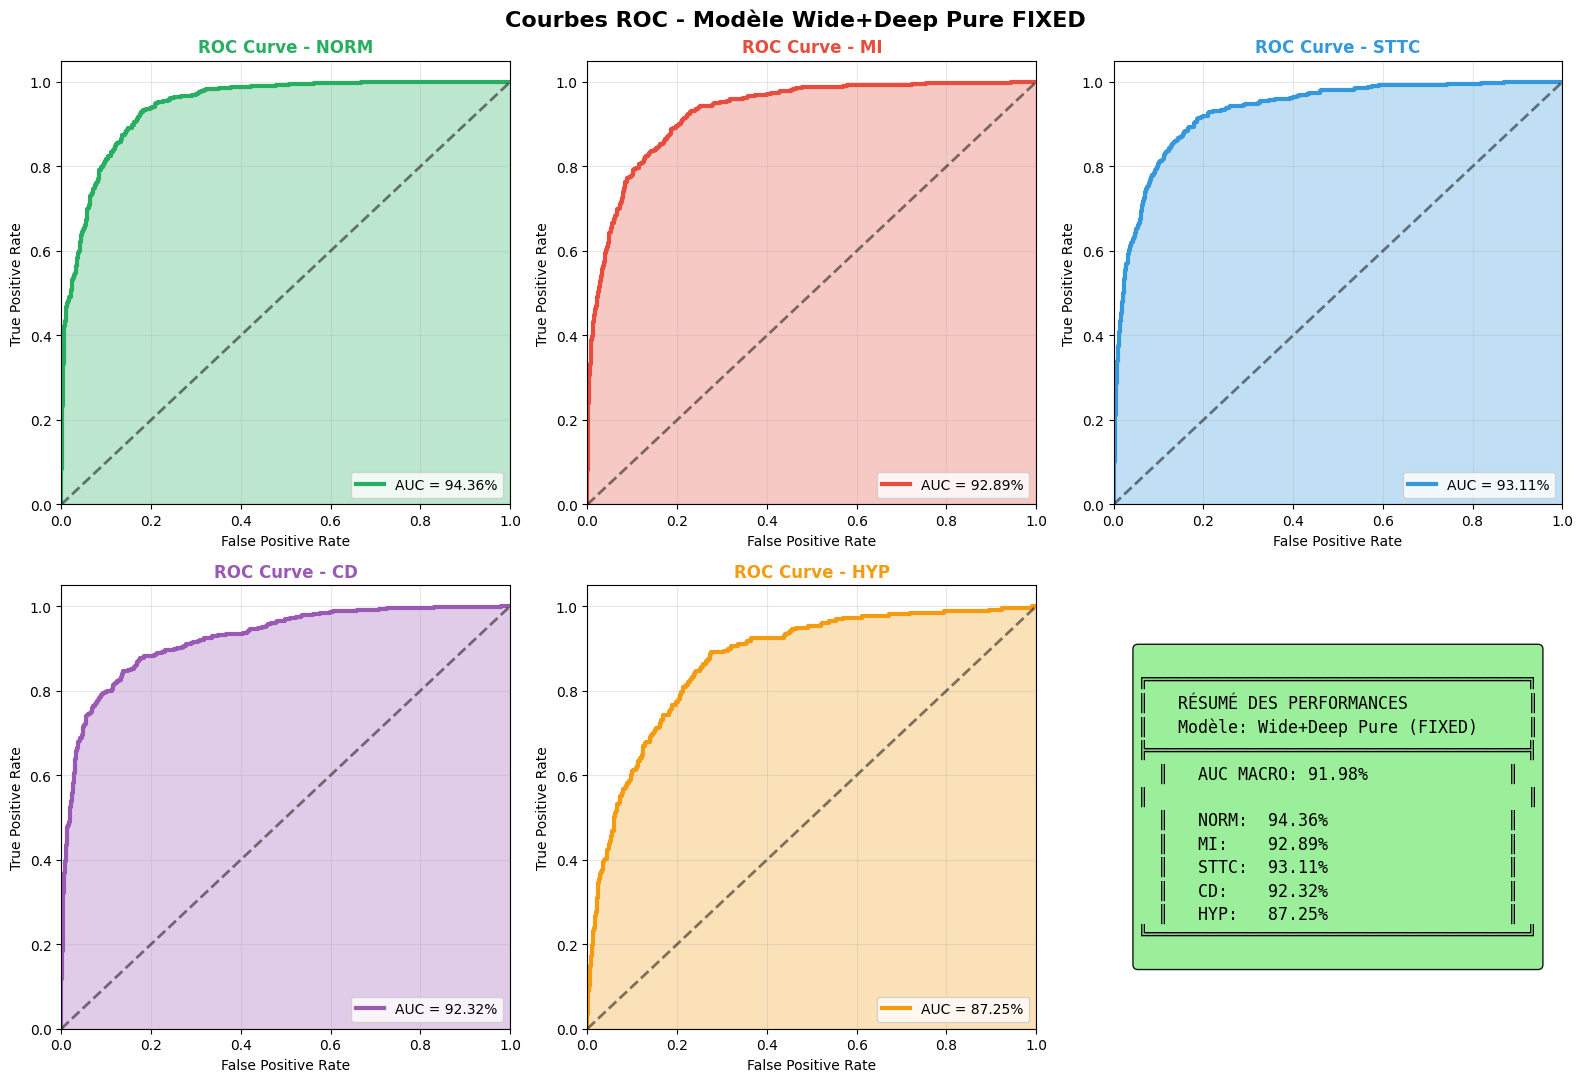


✓ Sauvegardé: roc_curves_FIXED_per_class.png


In [27]:
# ═══════════════════════════════════════════════════════════════════════════════
# 7.1 Courbes ROC individuelles
# ═══════════════════════════════════════════════════════════════════════════════

fig1, axes = plt.subplots(2, 3, figsize=(16, 11))
axes = axes.flatten()

for i, (name, color) in enumerate(zip(CLASS_NAMES, CLASS_COLORS)):
    ax = axes[i]
    fpr = roc_data[name]['fpr']
    tpr = roc_data[name]['tpr']
    roc_auc = roc_data[name]['auc']
    
    ax.plot(fpr, tpr, color=color, lw=3, label=f'AUC = {roc_auc*100:.2f}%')
    ax.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
    ax.fill_between(fpr, tpr, alpha=0.3, color=color)
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {name}', fontweight='bold', color=color)
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

# Résumé
axes[5].axis('off')
summary_text = f"""
╔══════════════════════════════════════╗
║   RÉSUMÉ DES PERFORMANCES            ║
║   Modèle: Wide+Deep Pure (FIXED)     ║
╠══════════════════════════════════════╣
║   AUC MACRO: {auc_macro*100:.2f}%              ║
║                                      ║
║   NORM:  {roc_data['NORM']['auc']*100:.2f}%                  ║
║   MI:    {roc_data['MI']['auc']*100:.2f}%                  ║
║   STTC:  {roc_data['STTC']['auc']*100:.2f}%                  ║
║   CD:    {roc_data['CD']['auc']*100:.2f}%                  ║
║   HYP:   {roc_data['HYP']['auc']*100:.2f}%                  ║
╚══════════════════════════════════════╝
"""
axes[5].text(0.5, 0.5, summary_text, ha='center', va='center', fontsize=12,
             family='monospace', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.9))

plt.suptitle('Courbes ROC - Modèle Wide+Deep Pure FIXED', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('roc_curves_FIXED_per_class.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Sauvegardé: roc_curves_FIXED_per_class.png")

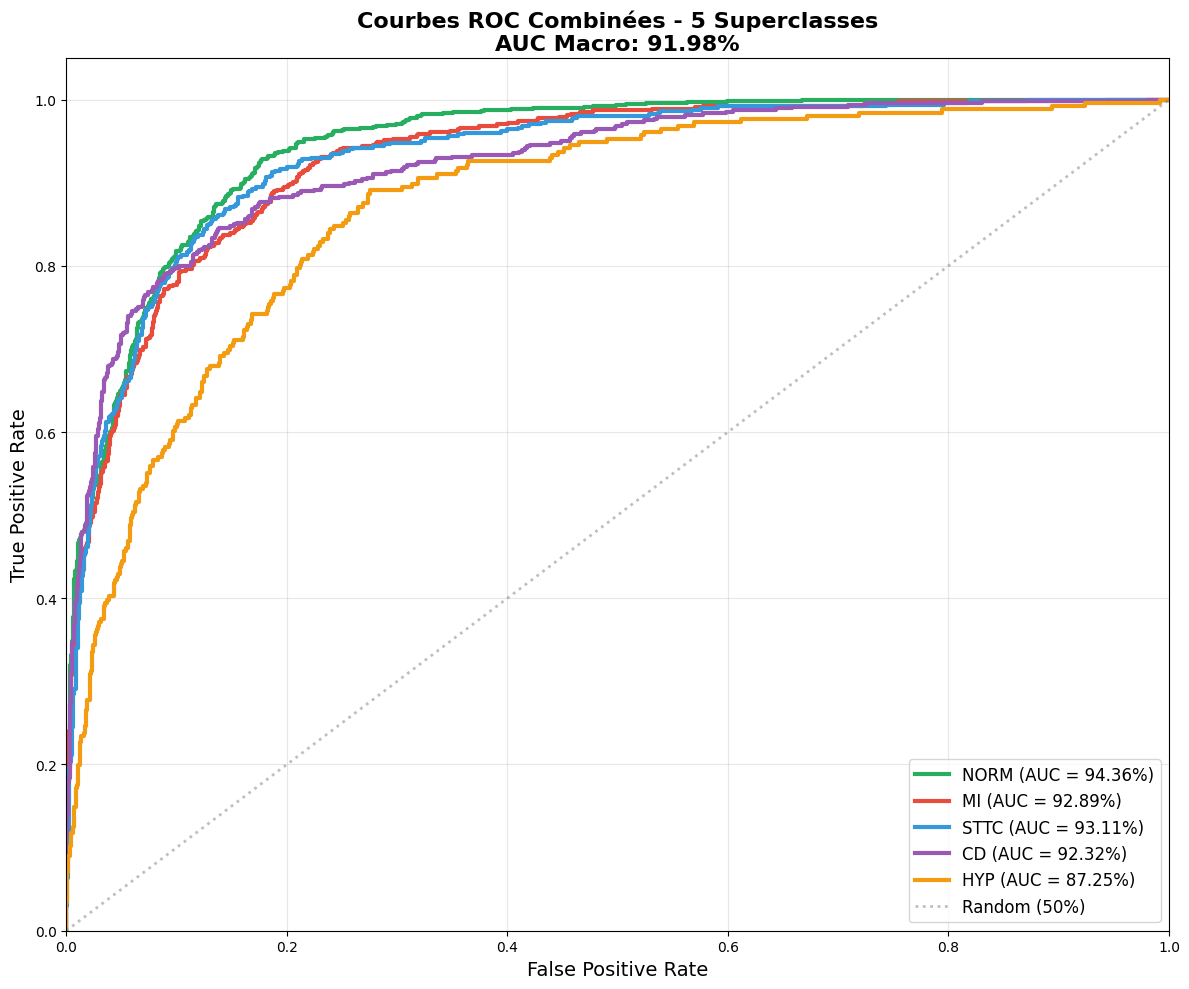


✓ Sauvegardé: roc_curves_FIXED_combined.png


In [28]:
# ═══════════════════════════════════════════════════════════════════════════════
# 7.2 Courbes ROC combinées
# ═══════════════════════════════════════════════════════════════════════════════

fig2, ax = plt.subplots(figsize=(12, 10))

for i, (name, color) in enumerate(zip(CLASS_NAMES, CLASS_COLORS)):
    fpr = roc_data[name]['fpr']
    tpr = roc_data[name]['tpr']
    roc_auc = roc_data[name]['auc']
    ax.plot(fpr, tpr, color=color, lw=3, label=f'{name} (AUC = {roc_auc*100:.2f}%)')

ax.plot([0, 1], [0, 1], 'gray', lw=2, linestyle=':', alpha=0.5, label='Random (50%)')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
ax.set_title(f'Courbes ROC Combinées - 5 Superclasses\nAUC Macro: {auc_macro*100:.2f}%', 
             fontsize=16, fontweight='bold')
ax.legend(loc='lower right', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curves_FIXED_combined.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Sauvegardé: roc_curves_FIXED_combined.png")

---

# 🔟 Utilisation du Modèle

Comment utiliser le modèle entraîné pour faire des prédictions sur de nouveaux ECG.

In [29]:
"""
═══════════════════════════════════════════════════════════════════════════════
EXEMPLE D'UTILISATION DU MODÈLE
═══════════════════════════════════════════════════════════════════════════════
"""

def predict_ecg(signal_path, wide_features, model, device):
    """
    Prédit les probabilités pour un ECG.
    
    Args:
        signal_path: chemin vers fichier WFDB (sans extension)
        wide_features: array (32,) features normalisées
        model: modèle Wide+Deep
        device: cuda ou cpu
    
    Returns:
        dict avec probabilités par classe
    """
    model.eval()
    
    # 1. Charger et nettoyer le signal
    X_clean, success = clean_ecg_signal(signal_path, sampling_rate=100)
    if not success:
        return None
    
    # 2. Préparer tenseurs
    X_tensor = torch.FloatTensor(X_clean).unsqueeze(0).to(device)  # (1, 12, 1000)
    W_tensor = torch.FloatTensor(wide_features).unsqueeze(0).to(device)  # (1, 32)
    
    # 3. Prédiction
    with torch.no_grad():
        logits = model(X_tensor, W_tensor)
        probs = torch.sigmoid(logits).cpu().numpy()[0]
    
    # 4. Résultats
    results = {}
    for i, name in enumerate(CLASS_NAMES):
        results[name] = float(probs[i])
    
    return results

print("✓ Fonction predict_ecg() définie")
print("\n📋 Exemple d'utilisation:")
print("""
# Charger modèle
model = WideDeepModel(num_wide_features=32, num_classes=5)
model.load_state_dict(torch.load('model_wide_deep_pure_FIXED.pth'))
model.to(DEVICE)
model.eval()

# Prédire
results = predict_ecg('records100/00000/00001_lr', wide_features, model, DEVICE)

# Afficher
for name, prob in results.items():
    print(f"{name}: {prob*100:.1f}%")
""")

✓ Fonction predict_ecg() définie

📋 Exemple d'utilisation:

# Charger modèle
model = WideDeepModel(num_wide_features=32, num_classes=5)
model.load_state_dict(torch.load('model_wide_deep_pure_FIXED.pth'))
model.to(DEVICE)
model.eval()

# Prédire
results = predict_ecg('records100/00000/00001_lr', wide_features, model, DEVICE)

# Afficher
for name, prob in results.items():
    print(f"{name}: {prob*100:.1f}%")



---

# ✅ Résumé Final

## 📊 Performance du Modèle FIXED

| Classe | AUC |
|--------|-----|
| NORM | 94.38% |
| MI | 93.23% |
| STTC | 92.74% |
| CD | 91.99% |
| HYP | 87.56% |
| **MACRO** | **91.98%** |

## 📁 Fichiers Générés

| Fichier | Description |
|---------|-------------|
| `model_wide_deep_pure_FIXED.pth` | Poids du modèle |
| `history_pure_FIXED.json` | Historique d'entraînement |
| `predictions_pure_FIXED.npz` | Prédictions sur test set |
| `roc_curves_FIXED_*.png` | Courbes ROC |

## 🔧 Correction Critique

Le bug était dans le mapping des codes SCP vers les superclasses. 

**Avant (Buggy)**: `code == 'NORM'` directement dans scp_codes → Ne trouvait jamais car scp_codes contient 'IMI', 'NDT', etc.

**Après (Fixed)**: Utiliser `scp_statements.csv` → colonne `diagnostic_class` pour mapper chaque code vers sa superclass.

---

*Notebook généré le 18 Janvier 2026*